# SIXT33N Controls | Open/Closed-Loop Control
## EECS16B: Designing Information Devices and Systems II, Spring 2021

## Table of Contents

* [Introduction](#intro)
 - [Lab Note](https://drive.google.com/file/d/1eJcav-nncRJO19HxB4HXCVb6RDUombo5/view?usp=sharing)
* [Part 1: Open Loop Control](#part1)
* [Part 2.1: Closed Loop Design](#part21)
* [Part 2.2: Closed Loop Simulation and k-Value Selection](#part22)
* [Part 2.3: Closed Loop Implementation](#part23)
* [Part 2.4: k-Value Tuning](#part24)
* [Part 2.5: Steady-State Error Correction](#part25)
* [Part 3: Open Loop Comparison](#part3) 


<a id='part1'></a>
# <span style="color:blue">Part 1: Open Loop Control</span>

## 1.0 Introduction

### [Lab Note](https://drive.google.com/file/d/1eJcav-nncRJO19HxB4HXCVb6RDUombo5/view?usp=sharing)

Read the Introduction of the note to familiarize yourself with/remind yourself of the open-loop model.
In the last lab, you modeled the open-loop system, collected data, and determined the unknown parameters of your car.

This week, you'll implement the open-loop and closed-loop systems. By the end of this phase, you should be able to control the trajectory of the car. We will return to turning later in the project. **Remember to document all design choices you made and explain them in the project report.**

The goals of this phase are as follows:
- Controller design
- Closed loop simulation
- Move at constant speed + direction

### <span style="color:red">**Fill in your model parameters and target velocty from System ID below.**</span>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import utils
%matplotlib inline

In [4]:
# YOUR PARAMETERS HERE
theta_left = 0.3379;
theta_right = 0.318;
beta_left = -11.25;
beta_right = -11.46;
v_star = 53.8;

simulator = utils.Simulator(theta_left, theta_right, beta_left, beta_right)

In [5]:
params = np.array([(theta_left, theta_right),
                   (beta_left, beta_right)])
d0 = (0,  0)
sim_length = 10 # sim length
mismatch_error = 0.1 # 10% model mismatch

<a id='part1.1'></a>
## 1.1 Open Loop Controller Design

### <a href="https://drive.google.com/file/d/1eJcav-nncRJO19HxB4HXCVb6RDUombo5/view">Read Part 1 of the note before you proceed. Boxed questions make good checkoff questions ;)</a>

Now design an open loop controller that uses the desired wheel velocity, `v_star`, to set the input `u` to an appropriate value for the pulse width modulation (PWM). To do this, solve your model from the previous part for the input $u[k]$ that makes the model velocity $d[k+1] - d[k]$ equal to the desired velocity $v^*$.

In [6]:
# DESIGN YOUR OPEN-LOOP CONTROL HERE
def drive_straight_left_ol(v_star):
    """Returns the open loop input 'u' for the left wheel"""
    # YOUR CODE HERE
    return (v_star + beta_left)/theta_left

def drive_straight_right_ol(v_star):
    """Returns the open loop input 'u' for the right wheel"""
    # YOUR CODE HERE
    return (v_star+beta_right)/theta_right

<a id='part1.2'></a>
## 1.2 Open Loop Simulation

### <a href="https://drive.google.com/file/d/1eJcav-nncRJO19HxB4HXCVb6RDUombo5/view">If you haven't yet, read Part 2 of the note.</a>

### Model Mismatch

Now, let's do a quick simulation to check the behavior of the car based on our functions above. In these simulations, we apply maximum PWM for a short time as we do in the real car to "jolt" the motors from a stop.

**Important:** As long as $\delta$ is constant, even if $\delta\neq 0$, the car still travels straight! Traveling straight means the *velocities*, not the positions, of the wheels are the same. It may just travel straight in a different direction than the original heading. Lets call the steady state (final) value $\delta_{ss}$.

In the left two plots, we assume the physical system perfectly matches our model. On the right, we assume the physical system is 10% different from our model.

Steady state error = 4.86
Steady state error = unbounded


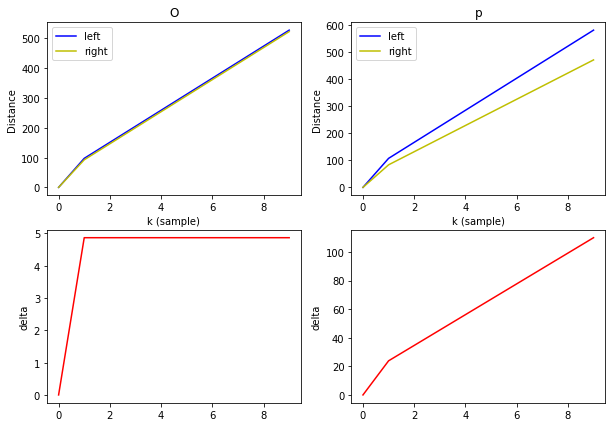

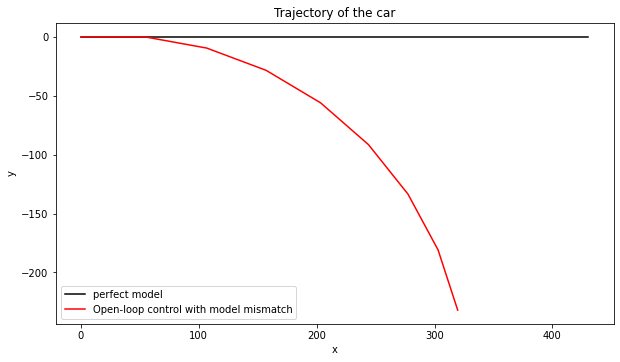

In [7]:
titles = "Open-loop control with model mismatch"

d_left, d_right = utils.two_sims(titles, 
                                 simulator, 
                                 v_star, 
                                 drive_straight_left_ol, 
                                 drive_straight_right_ol,
                                 sim_length=sim_length)
utils.plot_car_traj(titles, 
                    simulator, 
                    v_star, 
                    drive_straight_left_ol, 
                    drive_straight_right_ol,
                    mismatch_error=0.1,
                    sim_length=sim_length)

From the above plots, we can see that the open-loop car travels straight only with a perfect model.

### Noise

We also know that in the real world, there is noise being introduced by various sources (i.e. electrical, mechanical, measurement, and/or quantization noise). We can visualize the effects of this noise by deliberately adding random noise to the inputs `u` of our simulation. 

We have added a random gaussian noise to the inputs `u` of a magnitude equal to 5% of the total amplitude. Feel free to experiment with other values and see what happens. To do so, change the value of the `u_noise_factor` variable in the noisy model instantiation (a value of 0.05 means 5%, and so on).

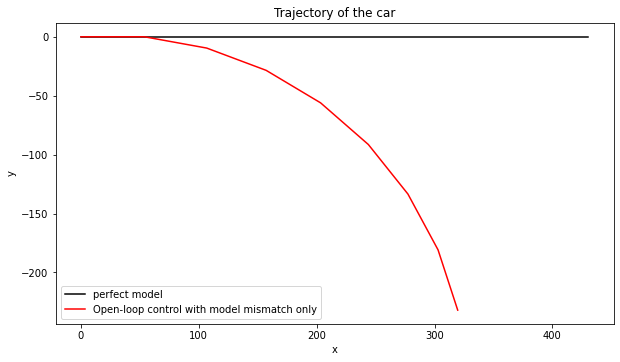

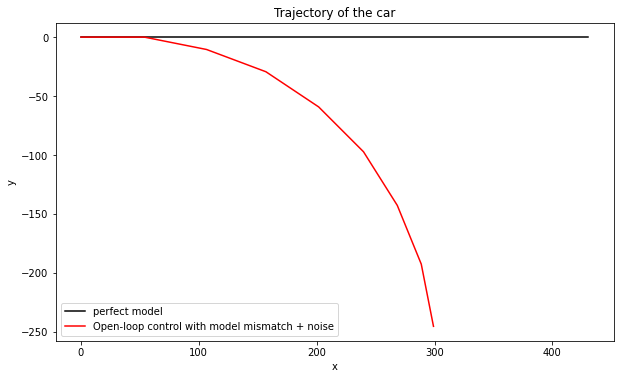

In [8]:
titles = ["Open-loop control with model mismatch only",
          "Open-loop control with model mismatch + noise"]

## Simulating noiseless model
utils.plot_car_traj(titles[0], 
                    simulator, 
                    v_star, 
                    drive_straight_left_ol, 
                    drive_straight_right_ol,
                    mismatch_error=0.1,
                    sim_length=sim_length,
                    u_noise_factor=0.0)


## Simulating noisy model
utils.plot_car_traj(titles[1], 
                    simulator, 
                    v_star, 
                    drive_straight_left_ol, 
                    drive_straight_right_ol,
                    mismatch_error=0.1,
                    sim_length=sim_length,
                    u_noise_factor=0.05)



<a id='part1.3'></a>
## 1.3 Jolt Calculation

### <a href="https://drive.google.com/file/d/1eJcav-nncRJO19HxB4HXCVb6RDUombo5/view">Before you proceed, read Part 3 of the note.</a>

We find the jolts below by calculating the inputs that result in the minimum of the maximum velocities of both wheels. 

- **Copy your `data_coarse.txt` file from System ID into the same directory as this iPython notebook.**
- Run the code below to find your initial jolt values.
- Your initial jolt values are correct if they are the input values that correspond to the points where the blue and yellow lines intersect the green line respectively.

int left_jolt = 190;
int right_jolt = 200;


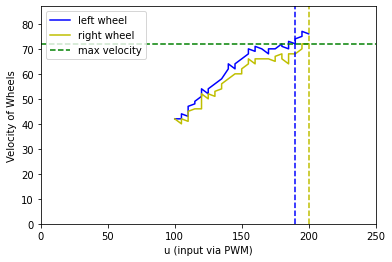

In [9]:
left_jolt, right_jolt = utils.find_jolt()
print('int left_jolt = {};\nint right_jolt = {};'.format(left_jolt, right_jolt))

<a id='part1.4'></a>
## 1.4 Open Loop Implementation

Now implement the controller on the Launchpad. The sketch **`open_loop.ino`** contains some code that implements the open loop control.

- Fill in these values in `CODE BLOCK CON1`:
    - desired velocity: `v_star` 
    - estimated parameters: `theta_left`, `theta_right`, `beta_left`, `beta_right`
    - initial jolt values: `left_jolt`, `right_jolt`
    
    
- Additionally, we need to compute the PWM input to the motors in `CODE BLOCK CON2`:
    - Complete `driveStraght_left_OL()` and `driveStraight_right_OL()` to compute `left_cur_pwm` and `right_cur_pwm` (the PWM inputs for each wheel required for a desired v_star)
    
    
- Fill out `CODE BLOCK CON0` to calculate the control inputs using the functions from `CODE BLOCK CON2`.
- Upload the sketch to your Launchpad.
- **Make sure that the car is suspended above the desk.** Your car wheels are going to move in this step.

Once you are satisfied that your motors work and your open loop control is implemented, put the car on the ground. Make sure the motor switch is on (and that both your motors are still plugged in) and press the `RST` button on your Launchpad. SIXT33N should move straighter than previously because you have accounted for differences in the two motors. Does it behave how you expect? It's okay if it doesn't drive completely straight at this stage.

-----

<a id='part2.0'></a>
# <span style="color:blue">Part 2: Closed Loop Control</span>

<a id='part21'></a>
## Closed Loop Design

Given the data you found in System ID, we know that the car does not match perfectly with our linear model *(think about why we know this)*. In order to correct for the imperfect model, we can build a closed loop controller that uses feedback to ensure that both wheels still drive at the same velocity. The controller has 2 inputs, namely the desired velocity and the difference between the wheel distances $\delta[k] = d_L[k] - d_R[k]$.

### 1. Please make sure you have read the [the note](https://drive.google.com/file/d/1eJcav-nncRJO19HxB4HXCVb6RDUombo5/view) before you begin. You may also find it helpful to read [this PDF](https://inst.eecs.berkeley.edu/~ee16b/fa17/proj/controls-primer.pdf) for the derivation of the closed-loop system and its eigenvalue.

<span style='color:red'>**2. Using the information above, draw a block diagram of both wheels' controllers.**</span> Show this diagram to your GSI before moving on. Keep this somewhere, as you will use it in your report.

<span style='color:red'>**3. Now derive the closed loop update equation for the differences $\delta[k]$ corresponding to your controller.**</span> Keep this somewhere, as you will use it in your report.

Now that we've derived the model, we can begin implementing it. Fill in the two functions below.

In [10]:
# YOUR PARAMETERS HERE
theta_left = 0.3379;
theta_right = 0.318;
beta_left = -11.25;
beta_right = -11.46;
v_star = 53.8;

simulator = utils.Simulator(theta_left, theta_right, beta_left, beta_right)

In [11]:
# DESIGN YOUR CLOSED-LOOP CONTROL HERE USING k_left AND k_right AS YOUR FEEDBACK TERMS
def drive_straight_left_cl(v_star, delta):
    """Returns the closed loop input 'u' for the left wheel"""
    # YOUR CODE HERE
    return (v_star + beta_left)/theta_left - k_left*(delta/theta_left)

def drive_straight_right_cl(v_star, delta):
    """Returns the closed loop input 'u' for the right wheel"""
    # YOUR CODE HERE
    return (v_star + beta_right)/theta_right + k_right*(delta/theta_right)

<a id='part22'></a>
## Closed Loop Simulation and K-Value Selection

Next we need to choose values for the control gains so that the $\delta[k]$ update equation is stable. *Concept check: For what eigenvalues is a discrete system stable?* There should be a range of parameter values that make it stable, so we can tune the gains to get the desired performance.

Take a look at each pair of perfect/mismatched-model plots below for each k-value pair and relate how our choice in k-values affects the car's performance. For each pair of plots, ask yourself these questions:
1. Does the car seem to drive straight in the perfectly matched model?
2. Does the car seem to correct for any errors that arise from a mismatched model? Does it end up driving straight?
3. How well does the car correct for errors?
3. Why do the chosen k-values make our system exhibit such behaviors?

<span style='color:red'>**Try the 5 different sets of gains below and see the effect of each.**</span>

Steady state error = 4.86
Steady state error = unbounded
kL=-0.3, kR=0.3
Eigenvalue of system: 1-kL-kR=1; marginally stable


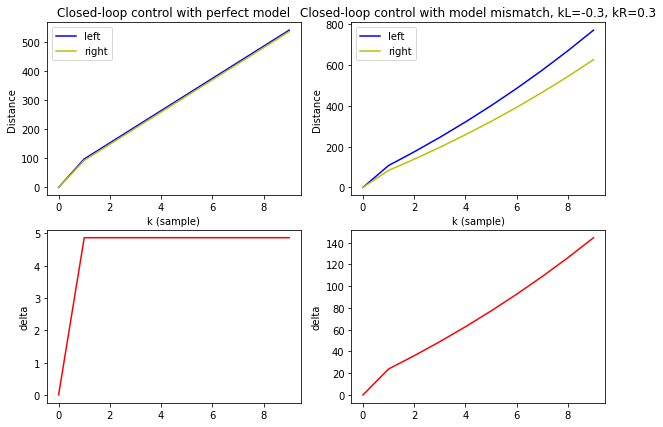

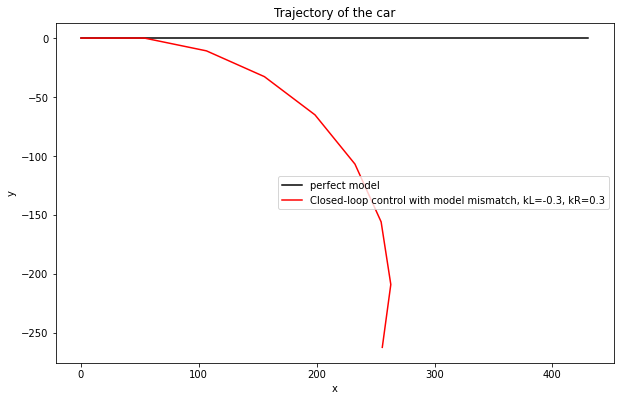

Steady state error = 0.00
Steady state error = 10.76
kL=0.5, kR=0.5
Eigenvalue of system: 1-kL-kR=0; stable, corrects error in one step


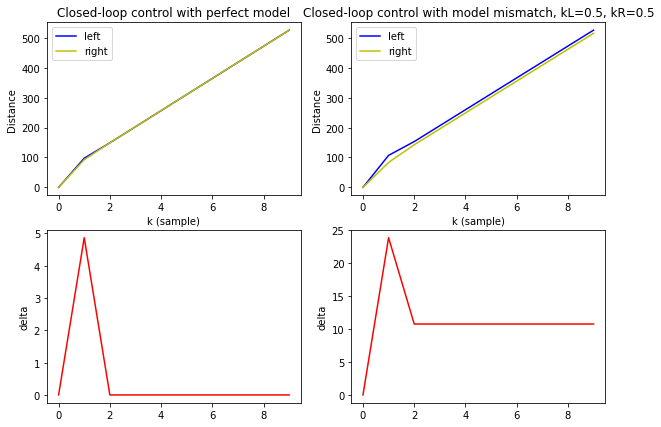

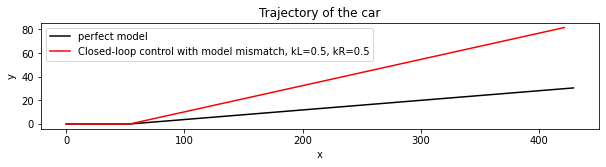

Steady state error = oscillatory
Steady state error = oscillatory
kL=1, kR=1
Eigenvalue of system: 1-kL-kR=-1; oscillatory, marginally stable


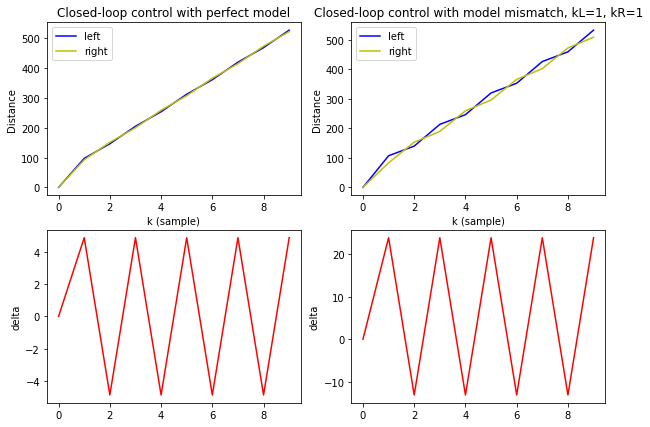

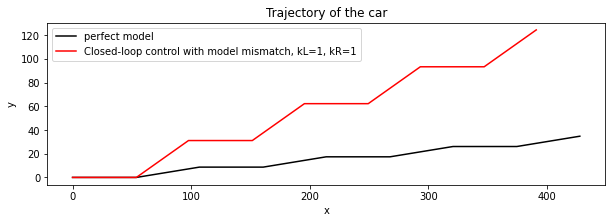

Steady state error = unbounded
Steady state error = unbounded
kL=1.1, kR=1.1
Eigenvalue of system: 1-kL-kR=-1.2; oscillatory, unstable


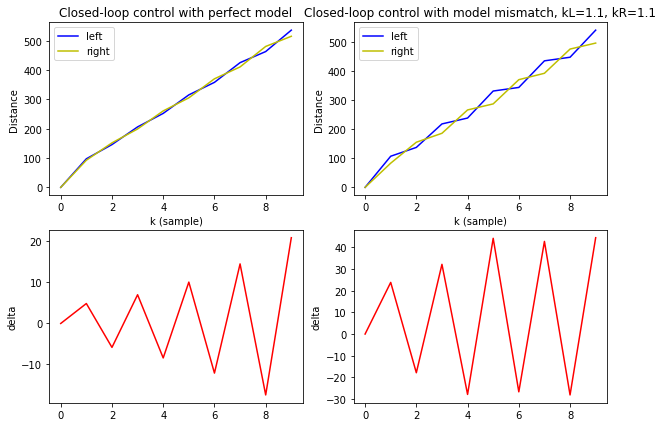

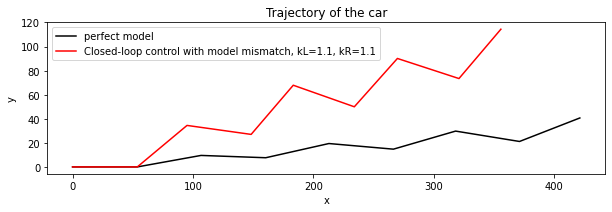

Steady state error = 0.00
Steady state error = 26.85
kL=0.2, kR=0.2
Eigenvalue of system: 1-kL-kR=0.6; stable


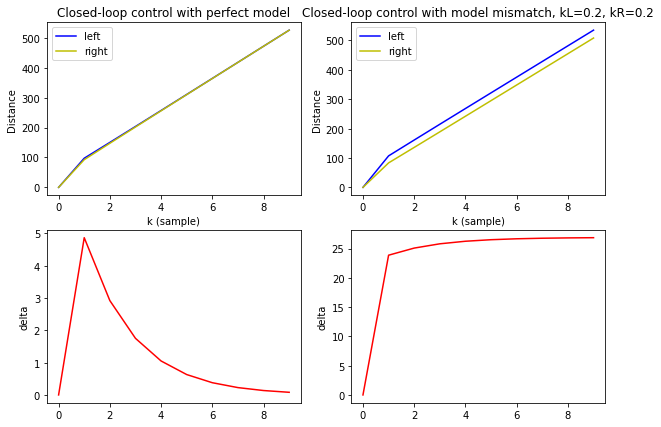

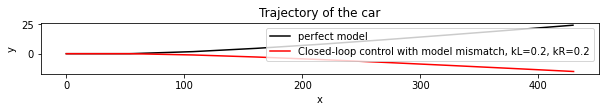

Steady state error = 0.00
Steady state error = 25.84
kL=0.28, kR=0.12
Eigenvalue of system: 1-kL-kR=0.6; chosen k values


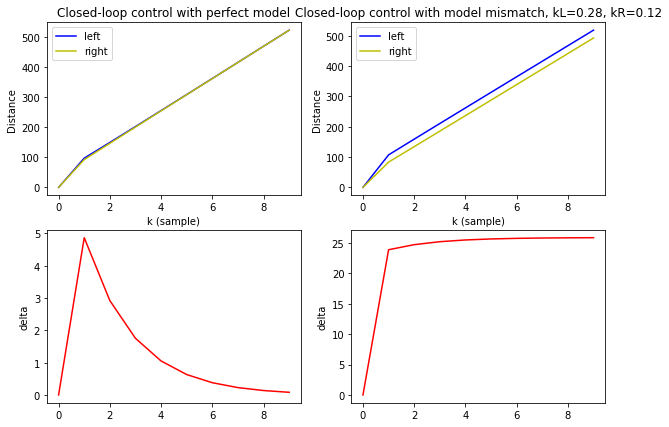

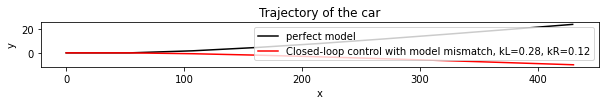

In [12]:
k_left, k_right = 0.28, 0.12
steady_state_error = 21

# Maps description of k_values to (k_left, k_right)
k_values = {
    "marginally stable": (-0.3, 0.3),
    "stable, corrects error in one step": (0.5, 0.5),
    "oscillatory, marginally stable": (1, 1),
    "oscillatory, unstable": (1.1, 1.1),
    "stable": (0.2, 0.2),
    "chosen k values": (0.28, 0.12)  # TODO: record your chosen k-values here
}

for key in k_values:
    k_left, k_right = k_values[key]

    titles = ["Closed-loop control with perfect model",
              "Closed-loop control with model mismatch, kL={}, kR={}".format(k_left, k_right)]
    _, delta = utils.two_sims(titles, 
                              simulator, 
                              v_star, 
                              drive_straight_left_cl, 
                              drive_straight_right_cl)
    utils.plot_car_traj(titles[1], 
                        simulator, 
                        v_star, 
                        drive_straight_left_cl, 
                        drive_straight_right_cl,
                        mismatch_error=0.1,
                        sim_length=sim_length)

    print("kL={}, kR={}".format(k_left, k_right))
    print("Eigenvalue of system: 1-kL-kR={:.2g}; {}".format(1-k_left-k_right, key))
    plt.show()
    steady_state_error = delta[-1]

<a id='part23'></a>
## Closed Loop Implementation

Now implement the controller on the Launchpad. The sketch **`closed_loop.ino`** contains some code that implements the closed loop control. 

- Fill out `CODE BLOCK CON1` with your control gains **`k_left`** and **`k_right`** as well as your theta, beta, and v_star values from System ID.
- Fill out `CODE BLOCK CON2` with your closed-loop control scheme.
- Fill out `CODE BLOCK CON0` in the body of the loop function to calculate the control inputs. Inspect this code to see how the control system is implemented. For now, ignore the term `delta_ss`, as it's currently set to 0.
- Upload the sketch to your LaunchPad.
    - Make sure that the car is suspended above the desk. Your car wheels are going to move in this step.
    - Check that the wheels are moving as you expect them to.
    - If you use your hand to put some friction on the wheels, does the feedback correct for it?

Once you are satisfied that your motors work and your closed-loop control is implemented, run the car on the ground. If it behaves erroneously (for example the controller oscillates), try different eigenvalues. Our simulations compare our possibly mismatched linear model with a linear approximation of our car. In reality, the car is a nonlinear system.

**Note:** It's possible that the car curves *slightly* over long distances, even if it the car thinks it's traveling straight. This can be due to factors such as mechanical differences past the shaft of the motor, including slight variation in wheel size or wheel wobble. We can fix this later in the next lab.

<span style='color:red'>**What are some reasons why the simulation might behave differently from the car? What about the differences between when the car is on the ground versus when it is on the desk?**</span>

<a id='part24'></a>
## K-Value Tuning

How did the car behave? It probably didn't go perfectly straight with the first set of k values that you picked. In order to find the "right" k values, we will need to analyze the behavior of our car. Recall in lecture that we learned about how the control values will affect the convergence of a system.


![](https://upload.wikimedia.org/wikipedia/commons/c/c0/Change_with_Ki.png)

The above plot can be summarized as:
- if k is too small, it takes a long time to converge to our desired solution
- if k is too big, oscillations happen

We can use this information to help guide us to k values that get our car going straight. Check out [this youtube playlist](https://www.youtube.com/playlist?list=PLQ1OVCqw6RUPgCmv8H6y9qbcMBT8lotDt) if you need some examples of what each case could look like.

You will likely have to try several sets of k values until you find one that works well with your particular car. If you find yourself having a lot of trouble narrowing in on some, ask your GSI for help!

Tips: 
 - Don't randomly guess on the k values! This will take you a long time to find the ones that make your car drive straight. Your tuning should always be based off of the previous iterations' behavior, don't just randomly choose values. Try to be smart about how you change the k values from iteration to iteration. If your car is turning to the left, think about how to change each k value, either by increasing or decreasing its value, to fix it.
 - If you're trying to figure out whether to increase or decrease your k_left or k_right based off of your car's behavior, you can set the values to two opposite extremes (ie k_left = .9, k_right = .1 or k_left = .1, k_right = .9) and test it to see which one makes your car drive straighter.


<a id='part25'></a>

## Steady State Error Correction

Lastly, what if we want the car to travel in (approximately) the same direction as when it starts moving? We can manually add the known steady state error $\delta_{ss}$ to each calculation of the error $\delta$. Accounting for the known $\delta_{ss}$ helps the model better respond to unexpected pertubations affecting $\delta$ which increases the model's control strength.

We now calculate $\delta[k]=d_L - d_R + \delta_{ss}$.


Steady state error = 0.00


Text(0, 0.5, 'delta')

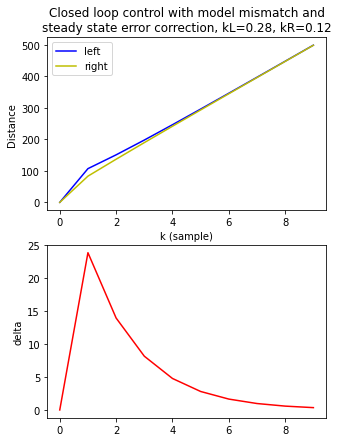

In [13]:
plt.figure(figsize=(5, 7))
plt.subplot(211)
# Simulate using steady_state_error
d = simulator.simulate(
    v_star, drive_straight_left_cl, drive_straight_right_cl, mismatch_error=0.1, offset=steady_state_error)
delta = simulator.plot(d)
plt.title("Closed loop control with model mismatch and\nsteady state error correction, kL={}, kR={}"
          .format(k_left, k_right))
plt.subplot(212)
plt.plot(delta, 'r')
plt.ylabel('delta')

- `closed_loop.ino` collects data as it runs, including $\delta[k]$. Like `dynamics_data.ino` from the System ID lab, data will be written to Flash Memory at the end of the run.
    - Set `WRITE = 1` at the top of the `closed_loop.ino` program.
    - Upload the program and hit `RST` on the launchpad.
    - Let the car run until it settles to (approximately) straight, it should do so by the time it naturally comes to a stop in the code.
    - Unplug the batteries from the car and unplug the `5V` pin of your launchpad from your regulator circuits.
    - Set `WRITE = 0` at the top of the `closed_loop.ino` program.
    - Upload the program to your launchpad and open the serial monitor.
    - Set the baud rate of the serial monitor to 38400.
    
- Note the steady-state value $\delta_{ss}$.
    - The first column of the printed data is $\delta$ over time.
    - **If $\delta$ doesn't reach steady-state (converging to a value), the car is not going straight according to the sensors.**
        - It's okay if it isn't exactly constant.
        - Just be sure the variation is small in proportion to the average value.

## Implementing Steady State Error Correction

- Input your value of $\delta_{ss}$ in `CODE BLOCK CON3` in **`closed_loop.ino`**.
- Convince yourself that we need to *add* this value in `CODE BLOCK CON0`.

For example, if the car drives straight but turned right from its initial heading, we want the right wheel to turn farther so it turns back towards the left. Adding a positive number to delta accomplishes this.

<a id='part3'></a>

## Open-Loop Comparison

To compare your control scheme to an open-loop model, you can set both of your K-values to zero. Try running your car with K-values of zero. Does your car behave similarly? Does it go straight?

Why do you think you see the behavior you see?

<img width='30px' align='left' src="http://inst.eecs.berkeley.edu/~ee16b/sp16/lab_pics/check.png">

## <span style="color:green">CHECKOFF</span>
 <span style="color:green">**Show your GSI that your car moves in a straight line.** Your GSI will also check your block diagram and k values.</span>